# Generate images and save as .npy file

## Import libraries

In [1]:
#creating responsive plot
%matplotlib widget

# Import packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from timeit import default_timer as timer
from typing import Dict, List
import platform
from scipy.stats import multivariate_normal, lognorm

cpu_info = platform.processor()
print(f"CPU Model: {cpu_info}\")

SyntaxError: unterminated string literal (detected at line 15) (4024434401.py, line 15)

In [4]:
# Import torchvision
import torch
import torch.nn as nn
import torchvision 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim

# Check version
print(f'Pytorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}\n')

# setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    gpu_memory_info = torch.cuda.get_device_properties(0)
    total_memory = gpu_memory_info.total_memory / (1024 ** 3)  # Convert to GB
    free_memory = torch.cuda.memory_reserved(0) / (1024 ** 3)  # Convert to GB
    used_memory = torch.cuda.memory_allocated(0) / (1024 ** 3)  # Convert to GB
    print(f"\nTotal GPU Memory: {total_memory:.2f} GB")
    print(f"Free GPU Memory: {free_memory:.2f} GB")
    print(f"Used GPU Memory: {used_memory:.2f} GB")
else:
    print("CUDA is not available.")

Pytorch version: 2.2.2
Torchvision version: 0.17.2

NVIDIA GeForce RTX 2070

Total GPU Memory: 8.00 GB
Free GPU Memory: 0.00 GB
Used GPU Memory: 0.00 GB


## Functions required for image generation

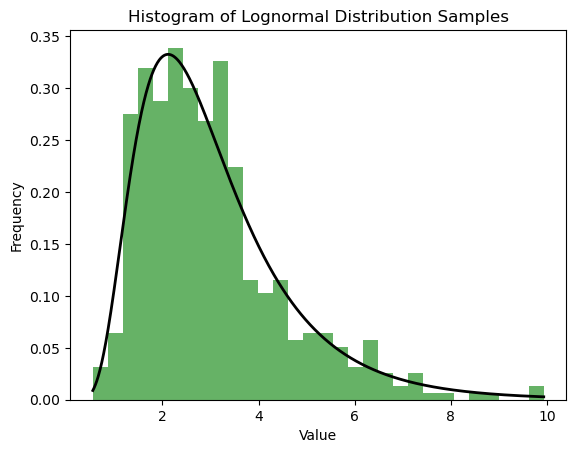

In [61]:
mu = 1          # Mean of the underlying normal distribution
sigma = 0.5   # Standard deviation of the underlying normal distribution (sqrt(variance))

# Generate random samples
samples = lognorm.rvs(s=sigma, scale=np.exp(mu), size=500)

# Plot histogram of the samples
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')

# Overlay the theoretical PDF
x = np.linspace(min(samples), max(samples), 1000)
pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
plt.plot(x, pdf, 'k', linewidth=2)

plt.title('Histogram of Lognormal Distribution Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [63]:
def generate_ratios(mean, cov, log_normal=False):
    if log_normal:
        # Generate log-normal distributed ratios for positive and skewed data
        s = np.sqrt(np.diag(cov))
        scale = np.exp(mean)
        a_c, b_c = lognorm.rvs(s=s, scale=scale, size=2).flatten()
    else:
        # Generate ratios from a 2D Gaussian distribution
        a_c, b_c = multivariate_normal.rvs(mean, cov)
    return a_c, b_c


mean = [0.1, 0.1]  # Mean for a/c and b/c ratios
variance_a = 0.2  # Variance for a/c
variance_b = 0.1  # Variance for b/c
cov_ab = 0.00  # Covariance between a/c and b/c

# Covariance matrix for the bivariate normal distribution
cov = [[variance_a, cov_ab], 
       [cov_ab, variance_b]]

for _ in range(20):
    a, b = generate_ratios(mean, cov, True)
    print(a,b)


# samples = multivariate_normal.rvs(mean=mean, cov=cov, size=500)

# # Plot the samples
# plt.scatter(samples[:, 0], samples[:, 1], marker='o', alpha=0.5)
# plt.title('Scatter Plot of Multivariate Normal Samples')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.axis('equal')
# plt.grid(True)
# plt.show()

0.7598049084917425 1.0326413324454133
1.454744682249549 1.3473664370892526
2.0507786139325646 1.7317606971297748
0.8663633194920097 1.0218972754130669
0.5721504354899751 1.9974503640597079
1.0393551863246648 1.3087372918806954
1.2795192545622227 0.9348244484884778
0.744835791229354 0.9236167651938983
1.0185217602258807 1.4485612364326053
1.707940251556238 0.9147423922976095
1.1230783376338231 0.9435792117087494
1.317504221896147 1.2955291254167132
1.125303362182173 0.7594818087732559
1.5123104740681206 0.9638006017291346
1.341166300151581 1.8479956523295857
0.4228756852288438 1.4149320807090988
1.347066280248542 0.9082353104366575
0.6012021934613274 2.0582584501154146
1.3665353546919599 1.2311034488728978
2.159768035654497 0.8076552524932192


In [56]:
def generate_ratios(mean, cov, log_normal=False):
    if log_normal:
        # Generate log-normal distributed ratios for positive and skewed data
        s = np.sqrt(np.diag(cov))
        scale = np.exp(mean)
        a_c, b_c = lognorm.rvs(s=s, scale=scale, size=2).flatten()
    else:
        # Generate ratios from a 2D Gaussian distribution
        a_c, b_c = multivariate_normal.rvs(mean, cov)
    return a_c, b_c

# Generate uniform points on surface of sphere for normal projections
def projection_points(radius, num_points):
    
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)
    
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    
    
    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

""" Functions that are used to generate filled sphere and
elipsoid"""

# Generate points on surface of sphere
def sphere(radius, num_points, plot=False):
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points) * radius)
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)

    if plot:
        # Plot Structure
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        plt.gca().set_aspect('auto', adjustable='box')
        ax.scatter(x,y,z, marker='.')
        ax.set_aspect('equal', 'box') #auto adjust limits
        #ax.axis('equal')
        ax.set_title('Structure of Circle', fontsize=10)
        plt.show()

    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

def ellipsoid(radius, num_points, mean, cov, log_normal=False, plot=False):
    # Generate random angles and radius for spherical coordinates
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points))
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    # Generate a/c and b/c ratios
    a_c, b_c = generate_ratios(mean, cov, log_normal)

    # Generate ellipsoid coordinates with the scaling factors
    x = a_c * radius * r * np.sin(phi) * np.cos(theta)
    y = b_c * radius * r * np.sin(phi) * np.sin(theta)
    z = radius * r * np.cos(phi)  # Here c is set to radius

    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, marker='.')
        ax.set_title(f'Ellipsoid with a/c={a_c:.2f}, b/c={b_c:.2f}')
        plt.show()
    
    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

def points_projection(structure_coords, num_points):
    """ 
    Functions for projection
    """
    # Assign structure coords into z
    z = structure_coords
    
    # normal vectors generation
    normal = projection_points(1, num_points)

    all_projected_points = []
    for n in normal:
        #Find two orthogonal vectors u and v (both orthogonal to n)
        #Calc value for t (random vector), ensuring not a scaled version of n
        if n[0] != 0:
            t = np.array([-(n[1]+n[2]) / n[0], 1, 1])
        elif n[1] != 0:
            t = np.array([-(n[0]+n[2]) / n[1], 1, 1])
        else:
            t = np.array([-(n[0]+n[1]) / n[2], 1, 1])
        
        u = np.cross(t,n)
        v = np.cross(n,u)
        
        # Normalize u and v (vector length become 1 unit long)
        u = u / np.linalg.norm(u)
        v = v / np.linalg.norm(v)
        
        vec_mat = np.array([u,v])
        
        #Project structure points onto plane
        #Individual component of normal
        a = n[0]
        b = n[1]
        c = n[2]
        #d = 0 #component of equation of planes

        projected_points = []
        for point in z:
            z1, z2, z3 = point
            
            k = (0 - a*z1 - b*z2 - c*z3) / (a**2 + b**2 + c**2) 
            
            p1 = z1 + k*a
            p2 = z2 + k*b
            p3 = z3 + k*c
            
            p = np.array([p1,p2,p3])

            #Convert 3D points to 2D
            p_trans = p.transpose()
            proj_2d = np.dot(vec_mat,p_trans)
            projected_points.append(proj_2d)
            
        all_projected_points.append(projected_points)

    return np.array(all_projected_points)


def cluster_per_cell(projected_points, image_size, grid_size):
    '''
    Functiom that transforms projections into grid and no of points
    '''
    all_projections = np.array(projected_points)
    image_size = image_size
    grid_x = grid_size[0]
    grid_y = grid_size[1]
    
    #Calc size of grid cell
    cell_x = image_size[0] / grid_x
    cell_y = image_size[1] / grid_y

    all_grid = []
    for projection in all_projections:
        grid = np.zeros((grid_x,grid_y), dtype=int)
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projection, axis=0)
        max_val = np.max(projection, axis=0)
        
        #Feature scaling 
        points_norm = (projection - min_val) / (max_val - min_val) 
        
        scaled_points = (points_norm * (np.array(image_size) - 1)).astype(int)
        
        for points in scaled_points:
            x,y = points
            gridx_index = int(x // cell_x) #floor division followed by conversion to integer
            gridy_index = int(y // cell_y)
            grid[gridy_index, gridx_index] += 1
            
        all_grid.append(grid)
        
    # transform into bw image 
    all_images = []
    for grid_img in all_grid:
        min = np.min(grid_img)
        max = np.max(grid_img)
        points_norm = (grid_img - min) / (max - min) 
        all_images.append(points_norm)

    return  all_images


def image_projection(coords, size):
    '''
    # Transform projected points into image with 1s and 0s
    '''
    all_projects = np.array(coords)
    image_size = size

    all_images = []
    for projects in all_projects:
    
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projects, axis=0)
        max_val = np.max(projects, axis=0)
        
        #Feature scaling 
        points_norm = (projects - min_val) / (max_val - min_val) 
        
        # Scale points to image size
        points_scaled = (points_norm * (np.array(image_size) -1 )).astype(int)
        
        # Create an empty image
        image = np.zeros(image_size)
        
        # Populate the image with points
        for point in points_scaled:
            x, y = point
            image[y,x] = 1  # Note: (y, x) because image coordinates are row-major
        
        all_images.append(image)
    
    return all_images


#Function that makes labels
def label_making(label_num, lst):
    label = [label_num] * len(lst)
    return label

def rotation(structure):
    point_cloud = structure
    
    # Convert to homogeneous coordinates
    point_cloud_homogeneous = []
    for point in structure:
        point_homogeneous = np.append(point,1)
        point_cloud_homogeneous.append(point_homogeneous)
    
    x, y, z= np.random.uniform(low = 0, high = 2 * np.pi, size=3)
    
    cx, sx = np.cos(x), np.sin(x)
    cy, sy = np.cos(y), np.sin(y)
    cz, sz = np.cos(z), np.sin(z)
    
    rotate_x = np.array([
        [1, 0, 0, 0],
        [0, cx, -sx, 0],
        [0, sx, cx, 0],
        [0, 0, 0, 1],
        ])

    rotate_y = np.array([
        [cy, 0, sy, 0],
        [0, 1, 0, 0],
        [-sy, 0, cy, 0],
        [0, 0, 0, 1],
        ])

    rotate_z = np.array([
        [cy, -sy, 0, 0],
        [-sy, cy, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        ])

    # Rotate in a 3 axis
    rotated_points = np.matmul(
        point_cloud_homogeneous,
        rotate_x)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_y)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_z)
    
    # Convert to cartesian coordinates
    rotated_points_xyz = []
    for point in rotated_points:
        point = np.array(point[:-1])
        rotated_points_xyz.append(point)

    return np.array(rotated_points_xyz)

def system_maker(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res):
    bw_img_all = []
    grid_img_all = []
    for _ in range(no_of_systems):
        systems = []
        no_of_spheres = np.random.randint(5,max_spheres) # min 5 sphere per system
        #no_of_spheres = max_spheres
        for _ in range(no_of_spheres):
            a = sphere(max_sphere_size, no_of_points) # create sphere
            a = a + (np.random.rand(1,3) * np.random.randint(10,20)) # translate sphere around
            systems.append(a) # add spheres
        
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that spheres coordinates in each systems combines

        # Project 3D system ontto 2D plane
        proj_2D = points_projection(systems,no_of_projections)
        
        # Transform 2D points into 1s ad 0s image & 0-1 range image
        image_bw = image_projection(proj_2D, image_res)
        image_contrast = cluster_per_cell(proj_2D, (720, 720), image_res)

        #bw_img_all.append(image_bw)
        grid_img_all.append(image_contrast)

    #bw_img_all = np.array(bw_img_all)
    grid_img_all = np.array(grid_img_all)
    #bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )

    return grid_img_all #bw_img_all

def system_maker2(no_of_systems ,max_ellipsoids, max_ellipsoid_size, no_of_points, no_of_projections, image_res):
    bw_img_all = []
    grid_img_all = []
    for _ in range(no_of_systems):
        systems = []
        no_of_ellipsoids = np.random.randint(5,max_ellipsoids) # min 5 sphere per system
        #no_of_spheres = max_spheres
        for _ in range(no_of_ellipsoids):
            a = ellipsoid(radius=max_ellipsoid_size, num_points=no_of_points, mean=mean, cov=cov, log_normal=False)
            #a = ellipsoid(max_ellipsoid_size, no_of_points) # create ellipsoid
            a = rotation(a)
            a = a + (np.random.rand(1,3) * np.random.randint(10, 20)) # translate sphere around
            systems.append(a) # add spheres
        
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that spheres coordinates in each systems combines

        # Project 3D system ontto 2D plane
        proj_2D = points_projection(systems,no_of_projections)
        
        # Transform 2D points into 1s ad 0s image & 0-1 range image
        #image_bw = image_projection(proj_2D, image_res)
        image_contrast = cluster_per_cell(proj_2D, (720, 720), image_res)

        #bw_img_all.append(image_bw)
        grid_img_all.append(image_contrast)

    #bw_img_all = np.array(bw_img_all)
    grid_img_all = np.array(grid_img_all)
    #bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )

    return grid_img_all #bw_img_all

In [106]:
def plot_images(image1, image2, image3, image4, filename):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    images = [image1, image2, image3, image4]
    titles = ['Sphere System 1', 'Sphere System 2', 'Ellipsoid System 1', 'Ellipsoid System 2']

    for idx, image in enumerate(images):
        # Determine the position in the 2x2 grid
        ax = axs[idx // 2, idx % 2]
        
        # Display the image
        ax.imshow(image, cmap='gray')
        
        # Set the predefined title for each subplot
        ax.set_title(titles[idx], fontsize=10)
        
        ax.axis('off')  # Hide the axes for a cleaner look

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'{filename}.png')
    plt.close(fig)
    
    
def plot_loss_curves(results: Dict[str, List[float]],filename):
    """ Plots training curves of a result dictionary """
    # Get loss value of result dictionary(training and testing)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get accuracy values of the result dictionary (training and testing)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    #Figure out no of epochs
    epochs = range(len(results["train_loss"]))
    
    #Setup plot
    # Setup plot
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the loss
    ax[0].plot(epochs, loss, label="Train_loss")
    ax[0].plot(epochs, test_loss, label="Test_loss")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].legend()

    # Plot the accuracy
    ax[1].plot(epochs, accuracy, label="Train_accuracy")
    ax[1].plot(epochs, test_accuracy, label="Test_accuracy")
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()

    # Save the figure
    plt.savefig(f'{filename}.png')
    plt.close(fig)

# takes in data and labels to transform into dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

In [108]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 32 * 32, 2)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

model = SimpleCNN()
model.to(device)
print('Model being used is SimpleCNN')

# create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # Put model in train mode
    model.train()
    
    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader, data batch
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device).unsqueeze(1), y.to(device)

        #1. Forward pass
        y_pred = model(X) #output model logits
        
        #2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #3. Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()

        #6. Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred) # total no correct divided by len of sample

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

# create test_step
def test_step(model:  torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    #Setup test loss and test accuract values
    test_loss, test_acc = 0, 0

    # Turn on inderence mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            #send data to target device
            X, y = X.to(device).unsqueeze(1), y.to(device)

            #1. Forward pass
            test_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            #3. Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    #Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss /  len(dataloader)
    test_acc = test_acc /  len(dataloader)
    return test_loss, test_acc


# Create train function
#1. Create a train function that takes in varius model parameters + optimizer + dataloaders
def train(model:torch.nn.Module,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10,
          device=device):

    #Create result dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # Loop through training and testing steps for x number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_data,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_data,
                                        loss_fn=loss_fn,
                                        device=device)
        #Print out what's happening
        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        #Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

Model being used is SimpleCNN


In [112]:
a = b = [0.1, 0.45, 0.7, 0.87]
mean = [1, 1]  # Mean for a/c and b/c ratios
cov_ab = 0.01  # Covariance between a/c and b/c
for i in range(len(a)):
    for j in range(len(b)):
        variance_a = a[i]  # Variance for a/c
        variance_b = b[j]  # Variance for b/c
        # Covariance matrix for the bivariate normal distribution
        cov = [[variance_a, cov_ab], 
               [cov_ab, variance_b]]
        start = time.time()
        '''system_maker(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res)'''
        
        sphere_img2 = system_maker(2,30,1,200,2,(64,64))
        ellips_img2 = system_maker2(2,30,1,200,2,(64,64))
        end = time.time()
        
        #images_bw = np.concatenate((sphere_img, ellips_img), axis=0)
        images_cont = np.concatenate((sphere_img2, ellips_img2), axis=0)
        
        # record time
        creation_time = end - start
        
        label = label_making(0, sphere_img)
        label2 = label_making(1, ellips_img)
        label.extend(label2)
        labels_array = np.array(label)
        
        #np.savez(f'images_{i}{j}',images_cont=images_cont, images_bw=images_bw, labels=labels_array)
        plot_images(images_cont[4],images_cont[0],images_cont[14],images_cont[11],f'image_a{i}_b{j}')
        print(f'variance a:{variance_a}, variance b:{variance_b}')
        print(f'System generation finished in {creation_time // 60:.0f} minutes {creation_time % 60:.0f} seconds {creation_time % 1 * 1000:.0f} milliseconds')

        #Data transformation
        data_array = np.array(images_cont)
    
        # Split data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(data_array, labels_array, test_size=0.2, random_state=42)
        #print(f"Training data shape: {X_train.shape}")
        #print(f"Validation data shape: {X_val.shape}")
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        
        
        # Instantiate the dataset
        BATCH_SIZE = 32
        NUM_WORKERS = 0 #os.cpu_count()
        
        train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
        val_dataset = CustomDataset(X_val_tensor, y_val_tensor)
        
        # Create DataLoader
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)
        
        #print(f'Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...')

        # Trainig begins
        # Set no of epochs (newnet)
        NUM_EPOCHS = 5
        
        # Setup loss function and optimizer
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        # optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
        
        # Start timer
        start_time = timer()
        
        # Train model
        model_results = train(model=model,
                             train_data=train_dataloader,
                             test_data=val_dataloader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS)
        # End timer and print out time taken
        end_time = timer()
        print(f"Total training time: {end_time-start_time:.3f} seconds")
        
        # Calculate parameters
        total_params = sum(p.numel() for p in model.parameters())
        print(f'Total parameters: {total_params}\n')
        plot_loss_curves(model_results, f'Loss_a{i}_b{j}')


variance a:0.1, variance b:0.1
System generation finished in 0 minutes 1 seconds 587 milliseconds
Epoch: 1 | Train loss: 0.6802 | Train acc: 0.5833 | Test loss: 0.7885 | Test acc: 0.2500
Epoch: 2 | Train loss: 0.6792 | Train acc: 0.5833 | Test loss: 0.7878 | Test acc: 0.2500
Total training time: 0.023 seconds
Total parameters: 32930

variance a:0.1, variance b:0.45
System generation finished in 0 minutes 1 seconds 505 milliseconds
Epoch: 1 | Train loss: 0.6852 | Train acc: 0.5833 | Test loss: 0.7836 | Test acc: 0.2500
Epoch: 2 | Train loss: 0.6835 | Train acc: 0.5833 | Test loss: 0.7835 | Test acc: 0.2500
Total training time: 0.024 seconds
Total parameters: 32930

variance a:0.1, variance b:0.7
System generation finished in 0 minutes 1 seconds 691 milliseconds
Epoch: 1 | Train loss: 0.6877 | Train acc: 0.5833 | Test loss: 0.8025 | Test acc: 0.2500
Epoch: 2 | Train loss: 0.6862 | Train acc: 0.5833 | Test loss: 0.8022 | Test acc: 0.2500
Total training time: 0.026 seconds
Total parameters

# Qsub script

## not used function
# Generate uniform points on surface of sphere for normal projections
def projection_points(radius, num_points):
    
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)
    
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    
    
    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

In [17]:
### Change Varience, same mean at 1,1, not log normal
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from timeit import default_timer as timer
from typing import Dict, List
from sklearn.model_selection import train_test_split
#import platform
from scipy.stats import multivariate_normal, lognorm
from sklearn.utils import shuffle
import os 

# Import torchvision
import torch
import torch.nn as nn
import torchvision 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

# Check version
print(f'Pytorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}\n')

# setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    gpu_memory_info = torch.cuda.get_device_properties(0)
    total_memory = gpu_memory_info.total_memory / (1024 ** 3)  # Convert to GB
    free_memory = torch.cuda.memory_reserved(0) / (1024 ** 3)  # Convert to GB
    used_memory = torch.cuda.memory_allocated(0) / (1024 ** 3)  # Convert to GB
    print(f"\nTotal GPU Memory: {total_memory:.2f} GB")
    print(f"Free GPU Memory: {free_memory:.2f} GB")
    print(f"Used GPU Memory: {used_memory:.2f} GB")
else:
    print("CUDA is not available.")
	
def generate_ratios(mean, cov, log_normal=False):
    if log_normal:
        # Generate log-normal distributed ratios for positive and skewed data
        s = np.sqrt(np.diag(cov))
        scale = np.exp(mean)
        a_c, b_c = lognorm.rvs(s=s, scale=scale, size=2).flatten()
    else:
        # Generate ratios from a 2D Gaussian distribution
        a_c, b_c = multivariate_normal.rvs(mean, cov)
    return a_c, b_c

""" Functions that are used to generate filled sphere and
elipsoid"""

# Generate points on surface of sphere
def sphere(radius, num_points, plot=False):
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points) * radius)
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)

    if plot:
        # Plot Structure
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        plt.gca().set_aspect('auto', adjustable='box')
        ax.scatter(x,y,z, marker='.')
        ax.set_aspect('equal', 'box') #auto adjust limits
        #ax.axis('equal')
        ax.set_title('Structure of Circle', fontsize=10)
        plt.show()

    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

def ellipsoid(radius, num_points, mean, cov, log_normal=False, plot=False):
    # Generate random angles and radius for spherical coordinates
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points))
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    # Generate a/c and b/c ratios
    a_c, b_c = generate_ratios(mean, cov, log_normal)

    # Generate ellipsoid coordinates with the scaling factors
    x = a_c * radius * r * np.sin(phi) * np.cos(theta)
    y = b_c * radius * r * np.sin(phi) * np.sin(theta)
    z = radius * r * np.cos(phi)  # Here c is set to radius

    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, marker='.')
        ax.set_title(f'Ellipsoid with a/c={a_c:.2f}, b/c={b_c:.2f}')
        plt.show()
    
    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

def points_projection(structure_coords, num_points):
    """ 
    Functions for projection
    """
    # Assign structure coords into z
    z = structure_coords
    
    # normal vectors generation
    normal = sphere(1, num_points)

    all_projected_points = []
    for n in normal:
        #Find two orthogonal vectors u and v (both orthogonal to n)
        #Calc value for t (random vector), ensuring not a scaled version of n
        if n[0] != 0:
            t = np.array([-(n[1]+n[2]) / n[0], 1, 1])
        elif n[1] != 0:
            t = np.array([-(n[0]+n[2]) / n[1], 1, 1])
        else:
            t = np.array([-(n[0]+n[1]) / n[2], 1, 1])
        
        u = np.cross(t,n)
        v = np.cross(n,u)
        
        # Normalize u and v (vector length become 1 unit long)
        u = u / np.linalg.norm(u)
        v = v / np.linalg.norm(v)
        
        vec_mat = np.array([u,v])
        
        #Project structure points onto plane
        #Individual component of normal
        a = n[0]
        b = n[1]
        c = n[2]
        #d = 0 #component of equation of planes

        projected_points = []
        for point in z:
            z1, z2, z3 = point
            
            k = (0 - a*z1 - b*z2 - c*z3) / (a**2 + b**2 + c**2) 
            
            p1 = z1 + k*a
            p2 = z2 + k*b
            p3 = z3 + k*c
            
            p = np.array([p1,p2,p3])

            #Convert 3D points to 2D
            p_trans = p.transpose()
            proj_2d = np.dot(vec_mat,p_trans)
            projected_points.append(proj_2d)
            
        all_projected_points.append(projected_points)

    return np.array(all_projected_points)


def cluster_per_cell(projected_points, image_size, grid_size):
    '''
    Functiom that transforms projections into grid and no of points
    '''
    all_projections = np.array(projected_points)
    image_size = image_size
    grid_x = grid_size[0]
    grid_y = grid_size[1]
    
    #Calc size of grid cell
    cell_x = image_size[0] / grid_x
    cell_y = image_size[1] / grid_y

    all_grid = []
    for projection in all_projections:
        grid = np.zeros((grid_x,grid_y), dtype=int)
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projection, axis=0)
        max_val = np.max(projection, axis=0)
        
        #Feature scaling 
        points_norm = (projection - min_val) / (max_val - min_val) 
        
        scaled_points = (points_norm * (np.array(image_size) - 1)).astype(int)
        
        for points in scaled_points:
            x,y = points
            gridx_index = int(x // cell_x) #floor division followed by conversion to integer
            gridy_index = int(y // cell_y)
            grid[gridy_index, gridx_index] += 1
            
        all_grid.append(grid)
        
    # transform into bw image 
    all_images = []
    for grid_img in all_grid:
        min = np.min(grid_img)
        max = np.max(grid_img)
        points_norm = (grid_img - min) / (max - min) 
        all_images.append(points_norm)

    return  all_images


def image_projection(coords, size):
    '''
    # Transform projected points into image with 1s and 0s
    '''
    all_projects = np.array(coords)
    image_size = size

    all_images = []
    for projects in all_projects:
    
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projects, axis=0)
        max_val = np.max(projects, axis=0)
        
        #Feature scaling 
        points_norm = (projects - min_val) / (max_val - min_val) 
        
        # Scale points to image size
        points_scaled = (points_norm * (np.array(image_size) -1 )).astype(int)
        
        # Create an empty image
        image = np.zeros(image_size)
        
        # Populate the image with points
        for point in points_scaled:
            x, y = point
            image[y,x] = 1  # Note: (y, x) because image coordinates are row-major
        
        all_images.append(image)
    
    return all_images


#Function that makes labels
def label_making(label_num, lst):
    label = [label_num] * len(lst)
    return label

def rotation(structure):
    point_cloud = structure
    
    # Convert to homogeneous coordinates
    point_cloud_homogeneous = []
    for point in structure:
        point_homogeneous = np.append(point,1)
        point_cloud_homogeneous.append(point_homogeneous)
    
    x, y, z= np.random.uniform(low = 0, high = 2 * np.pi, size=3)
    
    cx, sx = np.cos(x), np.sin(x)
    cy, sy = np.cos(y), np.sin(y)
    cz, sz = np.cos(z), np.sin(z)
    
    rotate_x = np.array([
        [1, 0, 0, 0],
        [0, cx, -sx, 0],
        [0, sx, cx, 0],
        [0, 0, 0, 1],
        ])

    rotate_y = np.array([
        [cy, 0, sy, 0],
        [0, 1, 0, 0],
        [-sy, 0, cy, 0],
        [0, 0, 0, 1],
        ])

    rotate_z = np.array([
        [cy, -sy, 0, 0],
        [-sy, cy, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        ])

    # Rotate in a 3 axis
    rotated_points = np.matmul(
        point_cloud_homogeneous,
        rotate_x)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_y)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_z)
    
    # Convert to cartesian coordinates
    rotated_points_xyz = []
    for point in rotated_points:
        point = np.array(point[:-1])
        rotated_points_xyz.append(point)

    return np.array(rotated_points_xyz)

    
def plot_images(image1, image2, image3, image4, filename):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    images = [image1, image2, image3, image4]
    titles = ['Sphere System 1', 'Sphere System 2', 'Ellipsoid System 1', 'Ellipsoid System 2']

    for idx, image in enumerate(images):
        # Determine the position in the 2x2 grid
        ax = axs[idx // 2, idx % 2]
        
        # Display the image
        ax.imshow(image, cmap='gray')
        
        # Set the predefined title for each subplot
        ax.set_title(titles[idx], fontsize=10)
        
        ax.axis('off')  # Hide the axes for a cleaner look

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'{filename}.png')
    plt.close(fig)
    
def plot_loss_curves(results: Dict[str, List[float]],filename):
    """ Plots training curves of a result dictionary """
    # Get loss value of result dictionary(training and testing)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get accuracy values of the result dictionary (training and testing)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    #Figure out no of epochs
    epochs = range(len(results["train_loss"]))
    
    #Setup plot
    # Setup plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the loss
    ax[0].plot(epochs, loss, label="Train_loss")
    ax[0].plot(epochs, test_loss, label="Test_loss")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].legend()

    # Plot the accuracy
    ax[1].plot(epochs, accuracy, label="Train_accuracy")
    ax[1].plot(epochs, test_accuracy, label="Test_accuracy")
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()

    # Save the figure
    plt.savefig(f'{filename}.png')
    plt.close(fig)



# takes in data and labels to transform into dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label
        
# CNN model    
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 32 * 32, 2)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

model = SimpleCNN()
model.to(device)
print('Model being used is SimpleCNN')

# create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # Put model in train mode
    model.train()
    
    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader, data batch
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device).unsqueeze(1), y.to(device)

        #1. Forward pass
        y_pred = model(X) #output model logits
        
        #2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #3. Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()

        #6. Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred) # total no correct divided by len of sample

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

# create test_step
def test_step(model:  torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    #Setup test loss and test accuract values
    test_loss, test_acc = 0, 0

    # Turn on inderence mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            #send data to target device
            X, y = X.to(device).unsqueeze(1), y.to(device)

            #1. Forward pass
            test_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            #3. Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    #Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss /  len(dataloader)
    test_acc = test_acc /  len(dataloader)
    return test_loss, test_acc


# Create train function
#1. Create a train function that takes in varius model parameters + optimizer + dataloaders
def train(model:torch.nn.Module,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10,
          device=device):

    #Create result dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # Loop through training and testing steps for x number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_data,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_data,
                                        loss_fn=loss_fn,
                                        device=device)
        #Print out what's happening
        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        #Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results
    
def system_maker(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res, distance):
    bw_img_all = []
    grid_img_all = []
    for _ in range(no_of_systems):
        systems = []
        no_of_spheres = np.random.randint(5,max_spheres) # min 5 sphere per system
        #no_of_spheres = max_spheres
        for _ in range(no_of_spheres):
            a = sphere(max_sphere_size, no_of_points) # create sphere
            a = a + (np.random.rand(1,3) * np.random.randint(1,distance)) # translate sphere around
            systems.append(a) # add spheres
        
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that spheres coordinates in each systems combines

        # Project 3D system ontto 2D plane
        proj_2D = points_projection(systems,no_of_projections)
        
        # Transform 2D points into 1s ad 0s image & 0-1 range image
        image_bw = image_projection(proj_2D, image_res)
        image_contrast = cluster_per_cell(proj_2D, (720, 720), image_res)

        #bw_img_all.append(image_bw)
        grid_img_all.append(image_contrast)

    #bw_img_all = np.array(bw_img_all)
    grid_img_all = np.array(grid_img_all)
    #bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )

    return grid_img_all #bw_img_all

def system_maker2(no_of_systems ,max_ellipsoids, max_ellipsoid_size, no_of_points, no_of_projections, image_res, distance, status=False):
    bw_img_all = []
    grid_img_all = []
    for _ in range(no_of_systems):
        systems = []
        no_of_ellipsoids = np.random.randint(5,max_ellipsoids) # min 5 sphere per system
        #no_of_spheres = max_spheres
        for _ in range(no_of_ellipsoids):
            a = ellipsoid(radius=max_ellipsoid_size, num_points=no_of_points, mean=mean, cov=cov, log_normal=status)
            #a = ellipsoid(max_ellipsoid_size, no_of_points) # create ellipsoid
            a = rotation(a)
            a = a + (np.random.rand(1,3) * np.random.randint(1, distance)) # translate sphere around
            systems.append(a) # add spheres
        
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that spheres coordinates in each systems combines

        # Project 3D system ontto 2D plane
        proj_2D = points_projection(systems,no_of_projections)
        
        # Transform 2D points into 1s ad 0s image & 0-1 range image
        #image_bw = image_projection(proj_2D, image_res)
        image_contrast = cluster_per_cell(proj_2D, (720, 720), image_res)

        #bw_img_all.append(image_bw)
        grid_img_all.append(image_contrast)

    #bw_img_all = np.array(bw_img_all)
    grid_img_all = np.array(grid_img_all)
    #bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )

    return grid_img_all #bw_img_all	

## Test script
cov_ab = 0.01  # Covariance between a/c and b/c
variance_a = 0.3  # Variance for a/c
variance_b = 0.3  # Variance for b/c
mean = [0, 0]
cov = [[variance_a, cov_ab], 
       [cov_ab, variance_b]]

distances = [3, 50, 75, 100, 200, 300]
image_name = 'dens_img'
loss_name = 'dens_loss'
for d in distances:
    start = timer()
    '''system_maker(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res)'''
    
        # Generate training images
    sphere_img_train = system_maker(200, 30, 1, 100, 2, (64, 64),d)
    ellips_img_train = system_maker2(200, 30, 1, 100, 2, (64, 64),d, True)
    
    # Generate testing images with different parameters
    sphere_img_test = system_maker(20, 30, 1, 100, 2, (64, 64),d)
    ellips_img_test = system_maker2(20, 30, 1, 100, 2,(64, 64),d, True)

    end = timer()
    
    print(f'\nvariance a:{variance_a}, variance b:{variance_b}, mean: {mean}, covarient: {cov_ab}')
    print(f"Total generation time: {end-start:.3f} seconds")
    
    # Concatenate the training images and labels
    images_train = np.concatenate((sphere_img_train, ellips_img_train), axis=0)
    labels_train = label_making(0, sphere_img_train) + label_making(1, ellips_img_train)
    # plot_images(images_train[4],images_train[0],images_train[14],images_train[11],f'{image_name}_a{i}_b{j}')
    plot_images(images_train[4],images_train[0],images_train[14],images_train[11],f'{image_name}_dens{d}')
    
    # Concatenate the testing images and labels
    images_test = np.concatenate((sphere_img_test, ellips_img_test), axis=0)
    labels_test = label_making(0, sphere_img_test) + label_making(1, ellips_img_test)
    
    # Convert labels to numpy arrays
    labels_array_train = np.array(labels_train)
    labels_array_test = np.array(labels_test)
    
    # Shuffle the training data
    X_train, y_train = shuffle(images_train, labels_array_train, random_state=42)
    X_val, y_val = shuffle(images_test, labels_array_test, random_state=42)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}\n")
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    
    
    # Instantiate the dataset
    BATCH_SIZE = 32
    NUM_WORKERS = 0 #os.cpu_count()
    
    train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
    val_dataset = CustomDataset(X_val_tensor, y_val_tensor)
    
    # Create DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

    # Trainig begins
    # Set no of epochs (newnet)
    NUM_EPOCHS = 10

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    
    # Start timer
    start_time = timer()
    
    # Train model
    model_results = train(model=model,
                         train_data=train_dataloader,
                         test_data=val_dataloader,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS)
    # End timer and print out time taken
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")
    
    # Calculate parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total parameters: {total_params}\n')
    plot_loss_curves(model_results, f'Loss_dens_{d}')

Pytorch version: 2.2.2
Torchvision version: 0.17.2

NVIDIA GeForce RTX 2070

Total GPU Memory: 8.00 GB
Free GPU Memory: 0.06 GB
Used GPU Memory: 0.02 GB
Model being used is SimpleCNN

variance a:0.3, variance b:0.3, mean: [0, 0], covarient: 0.01
Total generation time: 15.884 seconds
Training data shape: (800, 64, 64)
Validation data shape: (80, 64, 64)

Epoch: 1 | Train loss: 0.7017 | Train acc: 0.5025 | Test loss: 0.6624 | Test acc: 0.6458
Epoch: 2 | Train loss: 0.6684 | Train acc: 0.5550 | Test loss: 0.6329 | Test acc: 0.6354
Epoch: 3 | Train loss: 0.6282 | Train acc: 0.6475 | Test loss: 0.5956 | Test acc: 0.7083
Epoch: 4 | Train loss: 0.5895 | Train acc: 0.7175 | Test loss: 0.5416 | Test acc: 0.7917
Epoch: 5 | Train loss: 0.5545 | Train acc: 0.7662 | Test loss: 0.4974 | Test acc: 0.8542
Epoch: 6 | Train loss: 0.5259 | Train acc: 0.7625 | Test loss: 0.4524 | Test acc: 0.8542
Epoch: 7 | Train loss: 0.5008 | Train acc: 0.7750 | Test loss: 0.4317 | Test acc: 0.8542
Epoch: 8 | Train loss

# Varience test

In [24]:
### Change Varience, same mean at 1,1, not log normal
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from timeit import default_timer as timer
from typing import Dict, List
from sklearn.model_selection import train_test_split
#import platform
from scipy.stats import multivariate_normal, lognorm
from sklearn.utils import shuffle
import os 

# Import torchvision
import torch
import torch.nn as nn
import torchvision 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

# Check version
print(f'Pytorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}\n')

# setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    gpu_memory_info = torch.cuda.get_device_properties(0)
    total_memory = gpu_memory_info.total_memory / (1024 ** 3)  # Convert to GB
    free_memory = torch.cuda.memory_reserved(0) / (1024 ** 3)  # Convert to GB
    used_memory = torch.cuda.memory_allocated(0) / (1024 ** 3)  # Convert to GB
    print(f"\nTotal GPU Memory: {total_memory:.2f} GB")
    print(f"Free GPU Memory: {free_memory:.2f} GB")
    print(f"Used GPU Memory: {used_memory:.2f} GB")
else:
    print("CUDA is not available.")
	
def generate_ratios(mean, cov, log_normal=False):
    if log_normal:
        # Generate log-normal distributed ratios for positive and skewed data
        s = np.sqrt(np.diag(cov))
        scale = np.exp(mean)
        a_c, b_c = lognorm.rvs(s=s, scale=scale, size=2).flatten()
    else:
        # Generate ratios from a 2D Gaussian distribution
        a_c, b_c = multivariate_normal.rvs(mean, cov)
    return a_c, b_c

""" Functions that are used to generate filled sphere and
elipsoid"""

# Generate points on surface of sphere
def sphere(radius, num_points, plot=False):
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points) * radius)
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)

    if plot:
        # Plot Structure
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        plt.gca().set_aspect('auto', adjustable='box')
        ax.scatter(x,y,z, marker='.')
        ax.set_aspect('equal', 'box') #auto adjust limits
        #ax.axis('equal')
        ax.set_title('Structure of Circle', fontsize=10)
        plt.show()

    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

def ellipsoid(radius, num_points, mean, cov, log_normal=False, plot=False):
    # Generate random angles and radius for spherical coordinates
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points))
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    # Generate a/c and b/c ratios
    a_c, b_c = generate_ratios(mean, cov, log_normal)

    # Generate ellipsoid coordinates with the scaling factors
    x = a_c * radius * r * np.sin(phi) * np.cos(theta)
    y = b_c * radius * r * np.sin(phi) * np.sin(theta)
    z = radius * r * np.cos(phi)  # Here c is set to radius

    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, marker='.')
        ax.set_title(f'Ellipsoid with a/c={a_c:.2f}, b/c={b_c:.2f}')
        plt.show()
    
    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

def points_projection(structure_coords, num_points):
    """ 
    Functions for projection
    """
    # Assign structure coords into z
    z = structure_coords
    
    # normal vectors generation
    normal = sphere(1, num_points)

    all_projected_points = []
    for n in normal:
        #Find two orthogonal vectors u and v (both orthogonal to n)
        #Calc value for t (random vector), ensuring not a scaled version of n
        if n[0] != 0:
            t = np.array([-(n[1]+n[2]) / n[0], 1, 1])
        elif n[1] != 0:
            t = np.array([-(n[0]+n[2]) / n[1], 1, 1])
        else:
            t = np.array([-(n[0]+n[1]) / n[2], 1, 1])
        
        u = np.cross(t,n)
        v = np.cross(n,u)
        
        # Normalize u and v (vector length become 1 unit long)
        u = u / np.linalg.norm(u)
        v = v / np.linalg.norm(v)
        
        vec_mat = np.array([u,v])
        
        #Project structure points onto plane
        #Individual component of normal
        a = n[0]
        b = n[1]
        c = n[2]
        #d = 0 #component of equation of planes

        projected_points = []
        for point in z:
            z1, z2, z3 = point
            
            k = (0 - a*z1 - b*z2 - c*z3) / (a**2 + b**2 + c**2) 
            
            p1 = z1 + k*a
            p2 = z2 + k*b
            p3 = z3 + k*c
            
            p = np.array([p1,p2,p3])

            #Convert 3D points to 2D
            p_trans = p.transpose()
            proj_2d = np.dot(vec_mat,p_trans)
            projected_points.append(proj_2d)
            
        all_projected_points.append(projected_points)

    return np.array(all_projected_points)


def cluster_per_cell(projected_points, image_size, grid_size):
    '''
    Functiom that transforms projections into grid and no of points
    '''
    all_projections = np.array(projected_points)
    image_size = image_size
    grid_x = grid_size[0]
    grid_y = grid_size[1]
    
    #Calc size of grid cell
    cell_x = image_size[0] / grid_x
    cell_y = image_size[1] / grid_y

    all_grid = []
    for projection in all_projections:
        grid = np.zeros((grid_x,grid_y), dtype=int)
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projection, axis=0)
        max_val = np.max(projection, axis=0)
        
        #Feature scaling 
        points_norm = (projection - min_val) / (max_val - min_val) 
        
        scaled_points = (points_norm * (np.array(image_size) - 1)).astype(int)
        
        for points in scaled_points:
            x,y = points
            gridx_index = int(x // cell_x) #floor division followed by conversion to integer
            gridy_index = int(y // cell_y)
            grid[gridy_index, gridx_index] += 1
            
        all_grid.append(grid)
        
    # transform into bw image 
    all_images = []
    for grid_img in all_grid:
        min = np.min(grid_img)
        max = np.max(grid_img)
        points_norm = (grid_img - min) / (max - min) 
        all_images.append(points_norm)

    return  all_images


def image_projection(coords, size):
    '''
    # Transform projected points into image with 1s and 0s
    '''
    all_projects = np.array(coords)
    image_size = size

    all_images = []
    for projects in all_projects:
    
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projects, axis=0)
        max_val = np.max(projects, axis=0)
        
        #Feature scaling 
        points_norm = (projects - min_val) / (max_val - min_val) 
        
        # Scale points to image size
        points_scaled = (points_norm * (np.array(image_size) -1 )).astype(int)
        
        # Create an empty image
        image = np.zeros(image_size)
        
        # Populate the image with points
        for point in points_scaled:
            x, y = point
            image[y,x] = 1  # Note: (y, x) because image coordinates are row-major
        
        all_images.append(image)
    
    return all_images


#Function that makes labels
def label_making(label_num, lst):
    label = [label_num] * len(lst)
    return label

def rotation(structure):
    point_cloud = structure
    
    # Convert to homogeneous coordinates
    point_cloud_homogeneous = []
    for point in structure:
        point_homogeneous = np.append(point,1)
        point_cloud_homogeneous.append(point_homogeneous)
    
    x, y, z= np.random.uniform(low = 0, high = 2 * np.pi, size=3)
    
    cx, sx = np.cos(x), np.sin(x)
    cy, sy = np.cos(y), np.sin(y)
    cz, sz = np.cos(z), np.sin(z)
    
    rotate_x = np.array([
        [1, 0, 0, 0],
        [0, cx, -sx, 0],
        [0, sx, cx, 0],
        [0, 0, 0, 1],
        ])

    rotate_y = np.array([
        [cy, 0, sy, 0],
        [0, 1, 0, 0],
        [-sy, 0, cy, 0],
        [0, 0, 0, 1],
        ])

    rotate_z = np.array([
        [cy, -sy, 0, 0],
        [-sy, cy, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        ])

    # Rotate in a 3 axis
    rotated_points = np.matmul(
        point_cloud_homogeneous,
        rotate_x)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_y)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_z)
    
    # Convert to cartesian coordinates
    rotated_points_xyz = []
    for point in rotated_points:
        point = np.array(point[:-1])
        rotated_points_xyz.append(point)

    return np.array(rotated_points_xyz)

    
def plot_images(image1, image2, image3, image4, filename):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    images = [image1, image2, image3, image4]
    titles = ['Sphere System 1', 'Sphere System 2', 'Ellipsoid System 1', 'Ellipsoid System 2']

    for idx, image in enumerate(images):
        # Determine the position in the 2x2 grid
        ax = axs[idx // 2, idx % 2]
        
        # Display the image
        ax.imshow(image, cmap='gray')
        
        # Set the predefined title for each subplot
        ax.set_title(titles[idx], fontsize=10)
        
        ax.axis('off')  # Hide the axes for a cleaner look

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'{filename}.png')
    plt.close(fig)
    
def plot_loss_curves(results: Dict[str, List[float]],filename):
    """ Plots training curves of a result dictionary """
    # Get loss value of result dictionary(training and testing)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get accuracy values of the result dictionary (training and testing)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    #Figure out no of epochs
    epochs = range(len(results["train_loss"]))
    
    #Setup plot
    # Setup plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the loss
    ax[0].plot(epochs, loss, label="Train_loss")
    ax[0].plot(epochs, test_loss, label="Test_loss")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].legend()

    # Plot the accuracy
    ax[1].plot(epochs, accuracy, label="Train_accuracy")
    ax[1].plot(epochs, test_accuracy, label="Test_accuracy")
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()

    # Save the figure
    plt.savefig(f'{filename}.png')
    plt.close(fig)



# takes in data and labels to transform into dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label
        
# CNN model    
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 32 * 32, 2)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

model = SimpleCNN()
model.to(device)
print('Model being used is SimpleCNN')

# create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # Put model in train mode
    model.train()
    
    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader, data batch
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device).unsqueeze(1), y.to(device)

        #1. Forward pass
        y_pred = model(X) #output model logits
        
        #2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #3. Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()

        #6. Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred) # total no correct divided by len of sample

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

# create test_step
def test_step(model:  torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    #Setup test loss and test accuract values
    test_loss, test_acc = 0, 0

    # Turn on inderence mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            #send data to target device
            X, y = X.to(device).unsqueeze(1), y.to(device)

            #1. Forward pass
            test_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            #3. Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    #Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss /  len(dataloader)
    test_acc = test_acc /  len(dataloader)
    return test_loss, test_acc


# Create train function
#1. Create a train function that takes in varius model parameters + optimizer + dataloaders
def train(model:torch.nn.Module,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10,
          device=device):

    #Create result dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # Loop through training and testing steps for x number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_data,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_data,
                                        loss_fn=loss_fn,
                                        device=device)
        #Print out what's happening
        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        #Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results
    
def system_maker(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res, distance):
    bw_img_all = []
    grid_img_all = []
    for _ in range(no_of_systems):
        systems = []
        no_of_spheres = np.random.randint(5,max_spheres) # min 5 sphere per system
        #no_of_spheres = max_spheres
        for _ in range(no_of_spheres):
            a = sphere(max_sphere_size, no_of_points) # create sphere
            a = a + (np.random.rand(1,3) * np.random.randint(1,distance)) # translate sphere around
            systems.append(a) # add spheres
        
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that spheres coordinates in each systems combines

        # Project 3D system ontto 2D plane
        proj_2D = points_projection(systems,no_of_projections)
        
        # Transform 2D points into 1s ad 0s image & 0-1 range image
        image_bw = image_projection(proj_2D, image_res)
        image_contrast = cluster_per_cell(proj_2D, (720, 720), image_res)

        #bw_img_all.append(image_bw)
        grid_img_all.append(image_contrast)

    #bw_img_all = np.array(bw_img_all)
    grid_img_all = np.array(grid_img_all)
    #bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )

    return grid_img_all #bw_img_all

def system_maker2(no_of_systems ,max_ellipsoids, max_ellipsoid_size, no_of_points, no_of_projections, image_res, distance, status=False):
    bw_img_all = []
    grid_img_all = []
    for _ in range(no_of_systems):
        systems = []
        no_of_ellipsoids = np.random.randint(5,max_ellipsoids) # min 5 sphere per system
        #no_of_spheres = max_spheres
        for _ in range(no_of_ellipsoids):
            a = ellipsoid(radius=max_ellipsoid_size, num_points=no_of_points, mean=mean, cov=cov, log_normal=status)
            #a = ellipsoid(max_ellipsoid_size, no_of_points) # create ellipsoid
            a = rotation(a)
            a = a + (np.random.rand(1,3) * np.random.randint(1, distance)) # translate sphere around
            systems.append(a) # add spheres
        
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that spheres coordinates in each systems combines

        # Project 3D system ontto 2D plane
        proj_2D = points_projection(systems,no_of_projections)
        
        # Transform 2D points into 1s ad 0s image & 0-1 range image
        #image_bw = image_projection(proj_2D, image_res)
        image_contrast = cluster_per_cell(proj_2D, (720, 720), image_res)

        #bw_img_all.append(image_bw)
        grid_img_all.append(image_contrast)

    #bw_img_all = np.array(bw_img_all)
    grid_img_all = np.array(grid_img_all)
    #bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )

    return grid_img_all #bw_img_all	

## Test script
cov_ab = 0.01  # Covariance between a/c and b/c
variance_a = variance_b= [0.1, 0.5, 1, 1.2]
mean = [1, 1]
cov = [[variance_a, cov_ab], 
       [cov_ab, variance_b]]
d = 40
image_name = 'var_img'
loss_name = 'var_loss'

for i in range(len(variance_a)):
    for j in range(len(variance_b)):
        cov = [[variance_a[i], cov_ab], 
               [cov_ab, variance_b[j]]]
        start = timer()
        '''system_maker(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res)'''
        # Generate training images
        sphere_img_train = system_maker(100, 30, 1, 100, 2, (64, 64),d)
        ellips_img_train = system_maker2(100, 30, 1, 100, 2, (64, 64),d, False)
        
        # Generate testing images with different parameters
        sphere_img_test = system_maker(20, 30, 1, 100, 2, (64, 64),d)
        ellips_img_test = system_maker2(20, 30, 1, 100, 2,(64, 64),d, False)
    
        end = timer()
        
        print(f'\nvariance a:{variance_a}, variance b:{variance_b}, mean: {mean}, covarient: {cov_ab}')
        print(f"Total generation time: {end-start:.3f} seconds")
        
        # Concatenate the training images and labels
        images_train = np.concatenate((sphere_img_train, ellips_img_train), axis=0)
        labels_train = label_making(0, sphere_img_train) + label_making(1, ellips_img_train)
        # plot_images(images_train[4],images_train[0],images_train[14],images_train[11],f'{image_name}_a{i}_b{j}')
        plot_images(images_train[4],images_train[0],images_train[200],images_train[201],f'{image_name}_dens{d}')
        
        # Concatenate the testing images and labels
        images_test = np.concatenate((sphere_img_test, ellips_img_test), axis=0)
        labels_test = label_making(0, sphere_img_test) + label_making(1, ellips_img_test)
        
        # Convert labels to numpy arrays
        labels_array_train = np.array(labels_train)
        labels_array_test = np.array(labels_test)
        
        # Shuffle the training data
        X_train, y_train = shuffle(images_train, labels_array_train, random_state=42)
        X_val, y_val = shuffle(images_test, labels_array_test, random_state=42)
        
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}\n")
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        
        
        # Instantiate the dataset
        BATCH_SIZE = 32
        NUM_WORKERS = 0 #os.cpu_count()
        
        train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
        val_dataset = CustomDataset(X_val_tensor, y_val_tensor)
        
        # Create DataLoader
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)
    
        # Trainig begins
        # Set no of epochs (newnet)
        NUM_EPOCHS = 10
    
        # Setup loss function and optimizer
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        # optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
        
        # Start timer
        start_time = timer()
        
        # Train model
        model_results = train(model=model,
                             train_data=train_dataloader,
                             test_data=val_dataloader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS)
        # End timer and print out time taken
        end_time = timer()
        print(f"Total training time: {end_time-start_time:.3f} seconds")
        
        # Calculate parameters
        total_params = sum(p.numel() for p in model.parameters())
        print(f'Total parameters: {total_params}\n')
        plot_loss_curves(model_results, f'Loss_dens_{d}')

Pytorch version: 2.2.2
Torchvision version: 0.17.2

NVIDIA GeForce RTX 2070

Total GPU Memory: 8.00 GB
Free GPU Memory: 0.06 GB
Used GPU Memory: 0.02 GB
Model being used is SimpleCNN

variance a:[0.1, 0.5, 1, 1.2], variance b:[0.1, 0.5, 1, 1.2], mean: [1, 1], covarient: 0.01
Total generation time: 9.875 seconds
Training data shape: (400, 64, 64)
Validation data shape: (80, 64, 64)

Epoch: 1 | Train loss: 0.7006 | Train acc: 0.5288 | Test loss: 0.7192 | Test acc: 0.5000
Epoch: 2 | Train loss: 0.7059 | Train acc: 0.4856 | Test loss: 0.7032 | Test acc: 0.5000
Epoch: 3 | Train loss: 0.6907 | Train acc: 0.5264 | Test loss: 0.6921 | Test acc: 0.5208
Epoch: 4 | Train loss: 0.6833 | Train acc: 0.5721 | Test loss: 0.7178 | Test acc: 0.5000
Epoch: 5 | Train loss: 0.7239 | Train acc: 0.4880 | Test loss: 0.6926 | Test acc: 0.5000
Epoch: 6 | Train loss: 0.7229 | Train acc: 0.5312 | Test loss: 0.7073 | Test acc: 0.5000
Epoch: 7 | Train loss: 0.7083 | Train acc: 0.4976 | Test loss: 0.6886 | Test acc:

# Mean test

In [100]:
### Change Varience, same mean at 1,1, not log normal
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from timeit import default_timer as timer
from typing import Dict, List
from sklearn.model_selection import train_test_split
#import platform
from scipy.stats import multivariate_normal, lognorm, expon, powerlaw
from sklearn.utils import shuffle
import os 

# Import torchvision
import torch
import torch.nn as nn
import torchvision 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

# Check version
print(f'Pytorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}\n')

# setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    gpu_memory_info = torch.cuda.get_device_properties(0)
    total_memory = gpu_memory_info.total_memory / (1024 ** 3)  # Convert to GB
    free_memory = torch.cuda.memory_reserved(0) / (1024 ** 3)  # Convert to GB
    used_memory = torch.cuda.memory_allocated(0) / (1024 ** 3)  # Convert to GB
    print(f"\nTotal GPU Memory: {total_memory:.2f} GB")
    print(f"Free GPU Memory: {free_memory:.2f} GB")
    print(f"Used GPU Memory: {used_memory:.2f} GB")
else:
    print("CUDA is not available.")
	
def generate_ratios(mean, cov, distribution='gaussian'):
    if distribution == 'lognormal':
        # Use the mean and standard deviation to create log-normal distribution
        mean_a_c, mean_b_c = mean
        var_a_c, var_b_c = np.diag(cov)
        s_a_c = np.sqrt(var_a_c)
        s_b_c = np.sqrt(var_b_c)
        
        # Generate a/c and b/c from log-normal distributions
        a_c = lognorm.rvs(s=s_a_c, scale=np.exp(mean_a_c))
        b_c = lognorm.rvs(s=s_b_c, scale=np.exp(mean_b_c))
    
    elif distribution == 'exponential':
        # Use the mean as the scale parameter for exponential distribution
        a_c = expon.rvs(scale=mean[0])
        b_c = expon.rvs(scale=mean[1])
    
    elif distribution == 'powerlaw':
        # Generate a/c and b/c from a power law distribution
        # The parameter `a` controls the shape of the distribution
        a_c = powerlaw.rvs(a=mean[0], scale=1)
        b_c = powerlaw.rvs(a=mean[1], scale=1)
    
    else:  # Gaussian by default
        # Generate ratios from a 2D Gaussian distribution
        a_c, b_c = multivariate_normal.rvs(mean, cov)
    
    return a_c, b_c

""" Functions that are used to generate filled sphere and
elipsoid"""

# Generate points on surface of sphere
def sphere(radius, num_points, plot=False):
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points) * radius)
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)

    if plot:
        # Plot Structure
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        plt.gca().set_aspect('auto', adjustable='box')
        ax.scatter(x,y,z, marker='.')
        ax.set_aspect('equal', 'box') #auto adjust limits
        #ax.axis('equal')
        ax.set_title('Structure of Circle', fontsize=10)
        plt.show()

    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

def ellipsoid(radius, num_points, mean, cov, distribution='gaussian', plot=False):
    # Generate random angles and radius for spherical coordinates
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points))
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    # Generate a/c and b/c ratios
    a_c, b_c = generate_ratios(mean, cov, distribution)

    # Generate ellipsoid coordinates with the scaling factors
    x = a_c * radius * r * np.sin(phi) * np.cos(theta)
    y = b_c * radius * r * np.sin(phi) * np.sin(theta)
    z = radius * r * np.cos(phi)  # Here c is set to radius

    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, marker='.')
        ax.set_title(f'Ellipsoid with a/c={a_c:.2f}, b/c={b_c:.2f}')
        plt.show()
    
    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

def points_projection(structure_coords, num_points):
    """ 
    Functions for projection
    """
    # Assign structure coords into z
    z = structure_coords
    
    # normal vectors generation
    normal = sphere(1, num_points)

    all_projected_points = []
    for n in normal:
        #Find two orthogonal vectors u and v (both orthogonal to n)
        #Calc value for t (random vector), ensuring not a scaled version of n
        if n[0] != 0:
            t = np.array([-(n[1]+n[2]) / n[0], 1, 1])
        elif n[1] != 0:
            t = np.array([-(n[0]+n[2]) / n[1], 1, 1])
        else:
            t = np.array([-(n[0]+n[1]) / n[2], 1, 1])
        
        u = np.cross(t,n)
        v = np.cross(n,u)
        
        # Normalize u and v (vector length become 1 unit long)
        u = u / np.linalg.norm(u)
        v = v / np.linalg.norm(v)
        
        vec_mat = np.array([u,v])
        
        #Project structure points onto plane
        #Individual component of normal
        a = n[0]
        b = n[1]
        c = n[2]
        #d = 0 #component of equation of planes

        projected_points = []
        for point in z:
            z1, z2, z3 = point
            
            k = (0 - a*z1 - b*z2 - c*z3) / (a**2 + b**2 + c**2) 
            
            p1 = z1 + k*a
            p2 = z2 + k*b
            p3 = z3 + k*c
            
            p = np.array([p1,p2,p3])

            #Convert 3D points to 2D
            p_trans = p.transpose()
            proj_2d = np.dot(vec_mat,p_trans)
            projected_points.append(proj_2d)
            
        all_projected_points.append(projected_points)

    return np.array(all_projected_points)


def cluster_per_cell(projected_points, image_size, grid_size):
    '''
    Functiom that transforms projections into grid and no of points
    '''
    all_projections = np.array(projected_points)
    image_size = image_size
    grid_x = grid_size[0]
    grid_y = grid_size[1]
    
    #Calc size of grid cell
    cell_x = image_size[0] / grid_x
    cell_y = image_size[1] / grid_y

    all_grid = []
    for projection in all_projections:
        grid = np.zeros((grid_x,grid_y), dtype=int)
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projection, axis=0)
        max_val = np.max(projection, axis=0)
        
        #Feature scaling 
        points_norm = (projection - min_val) / (max_val - min_val) 
        
        scaled_points = (points_norm * (np.array(image_size) - 1)).astype(int)
        
        for points in scaled_points:
            x,y = points
            gridx_index = int(x // cell_x) #floor division followed by conversion to integer
            gridy_index = int(y // cell_y)
            grid[gridy_index, gridx_index] += 1
            
        all_grid.append(grid)
        
    # transform into bw image 
    all_images = []
    for grid_img in all_grid:
        min = np.min(grid_img)
        max = np.max(grid_img)
        points_norm = (grid_img - min) / (max - min) 
        all_images.append(points_norm)

    return  all_images


def image_projection(coords, size):
    '''
    # Transform projected points into image with 1s and 0s
    '''
    all_projects = np.array(coords)
    image_size = size

    all_images = []
    for projects in all_projects:
    
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projects, axis=0)
        max_val = np.max(projects, axis=0)
        
        #Feature scaling 
        points_norm = (projects - min_val) / (max_val - min_val) 
        
        # Scale points to image size
        points_scaled = (points_norm * (np.array(image_size) -1 )).astype(int)
        
        # Create an empty image
        image = np.zeros(image_size)
        
        # Populate the image with points
        for point in points_scaled:
            x, y = point
            image[y,x] = 1  # Note: (y, x) because image coordinates are row-major
        
        all_images.append(image)
    
    return all_images


#Function that makes labels
def label_making(label_num, lst):
    label = [label_num] * len(lst)
    return label

def rotation(structure):
    point_cloud = structure
    
    # Convert to homogeneous coordinates
    point_cloud_homogeneous = []
    for point in structure:
        point_homogeneous = np.append(point,1)
        point_cloud_homogeneous.append(point_homogeneous)
    
    x, y, z= np.random.uniform(low = 0, high = 2 * np.pi, size=3)
    
    cx, sx = np.cos(x), np.sin(x)
    cy, sy = np.cos(y), np.sin(y)
    cz, sz = np.cos(z), np.sin(z)
    
    rotate_x = np.array([
        [1, 0, 0, 0],
        [0, cx, -sx, 0],
        [0, sx, cx, 0],
        [0, 0, 0, 1],
        ])

    rotate_y = np.array([
        [cy, 0, sy, 0],
        [0, 1, 0, 0],
        [-sy, 0, cy, 0],
        [0, 0, 0, 1],
        ])

    rotate_z = np.array([
        [cy, -sy, 0, 0],
        [-sy, cy, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        ])

    # Rotate in a 3 axis
    rotated_points = np.matmul(
        point_cloud_homogeneous,
        rotate_x)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_y)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_z)
    
    # Convert to cartesian coordinates
    rotated_points_xyz = []
    for point in rotated_points:
        point = np.array(point[:-1])
        rotated_points_xyz.append(point)

    return np.array(rotated_points_xyz)

    
def plot_images(image1, image2, image3, image4, filename):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    images = [image1, image2, image3, image4]
    titles = ['Sphere System 1', 'Sphere System 2', 'Ellipsoid System 1', 'Ellipsoid System 2']

    for idx, image in enumerate(images):
        # Determine the position in the 2x2 grid
        ax = axs[idx // 2, idx % 2]
        
        # Display the image
        ax.imshow(image, cmap='gray')
        
        # Set the predefined title for each subplot
        ax.set_title(titles[idx], fontsize=10)
        
        ax.axis('off')  # Hide the axes for a cleaner look

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'{filename}.png')
    plt.close(fig)
    
def plot_loss_curves(results: Dict[str, List[float]],filename):
    """ Plots training curves of a result dictionary """
    # Get loss value of result dictionary(training and testing)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get accuracy values of the result dictionary (training and testing)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    #Figure out no of epochs
    epochs = range(len(results["train_loss"]))
    
    #Setup plot
    # Setup plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the loss
    ax[0].plot(epochs, loss, label="Train_loss")
    ax[0].plot(epochs, test_loss, label="Test_loss")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].legend()

    # Plot the accuracy
    ax[1].plot(epochs, accuracy, label="Train_accuracy")
    ax[1].plot(epochs, test_accuracy, label="Test_accuracy")
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()

    # Save the figure
    plt.savefig(f'{filename}.png')
    plt.close(fig)



# takes in data and labels to transform into dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label
        
# CNN model    
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 32 * 32, 2)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

model = SimpleCNN()
model.to(device)
print('Model being used is SimpleCNN')

# create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # Put model in train mode
    model.train()
    
    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader, data batch
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device).unsqueeze(1), y.to(device)

        #1. Forward pass
        y_pred = model(X) #output model logits
        
        #2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #3. Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()

        #6. Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred) # total no correct divided by len of sample

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

# create test_step
def test_step(model:  torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    #Setup test loss and test accuract values
    test_loss, test_acc = 0, 0

    # Turn on inderence mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            #send data to target device
            X, y = X.to(device).unsqueeze(1), y.to(device)

            #1. Forward pass
            test_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            #3. Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    #Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss /  len(dataloader)
    test_acc = test_acc /  len(dataloader)
    return test_loss, test_acc


# Create train function
#1. Create a train function that takes in varius model parameters + optimizer + dataloaders
def train(model:torch.nn.Module,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10,
          device=device):

    #Create result dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # Loop through training and testing steps for x number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_data,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_data,
                                        loss_fn=loss_fn,
                                        device=device)
        #Print out what's happening
        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        #Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results
    
def system_maker(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res, distance):
    bw_img_all = []
    grid_img_all = []
    for _ in range(no_of_systems):
        systems = []
        no_of_spheres = np.random.randint(5,max_spheres) # min 5 sphere per system
        #no_of_spheres = max_spheres
        for _ in range(no_of_spheres):
            a = sphere(max_sphere_size, no_of_points) # create sphere
            a = a + (np.random.rand(1,3) * np.random.randint(1,distance)) # translate sphere around
            systems.append(a) # add spheres
        
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that spheres coordinates in each systems combines

        # Project 3D system ontto 2D plane
        proj_2D = points_projection(systems,no_of_projections)
        
        # Transform 2D points into 1s ad 0s image & 0-1 range image
        image_bw = image_projection(proj_2D, image_res)
        image_contrast = cluster_per_cell(proj_2D, (720, 720), image_res)

        #bw_img_all.append(image_bw)
        grid_img_all.append(image_contrast)

    #bw_img_all = np.array(bw_img_all)
    grid_img_all = np.array(grid_img_all)
    #bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )

    return grid_img_all #bw_img_all

def system_maker2(no_of_systems ,max_ellipsoids, max_ellipsoid_size, no_of_points, no_of_projections, image_res, distance, distribution_type='gaussian'):
    bw_img_all = []
    grid_img_all = []
    for _ in range(no_of_systems):
        systems = []
        no_of_ellipsoids = np.random.randint(5,max_ellipsoids) # min 5 sphere per system
        #no_of_spheres = max_spheres
        for _ in range(no_of_ellipsoids):
            a = ellipsoid(radius=max_ellipsoid_size, num_points=no_of_points, mean=mean, cov=cov, distribution=distribution_type)
            a = rotation(a)
            a = a + (np.random.rand(1,3) * np.random.randint(1, distance)) # translate sphere around
            systems.append(a) # add spheres
        
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that spheres coordinates in each systems combines

        # Project 3D system ontto 2D plane
        proj_2D = points_projection(systems,no_of_projections)
        
        # Transform 2D points into 1s ad 0s image & 0-1 range image
        #image_bw = image_projection(proj_2D, image_res)
        image_contrast = cluster_per_cell(proj_2D, (720, 720), image_res)

        #bw_img_all.append(image_bw)
        grid_img_all.append(image_contrast)

    #bw_img_all = np.array(bw_img_all)
    grid_img_all = np.array(grid_img_all)
    #bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )

    return grid_img_all #bw_img_all	

## Test script
cov_ab = 0.01  # Covariance between a/c and b/c
variance_a = 0.3  # Variance for a/c
variance_b = 0.3  # Variance for b/c

mean_a = mean_b = [0, 0.5, 1, 1.5, 2]
cov = [[variance_a, cov_ab], 
       [cov_ab, variance_b]]

d = 40
image_name = 'meanL_img'
loss_name = 'meanL_loss'
for i in range(len(mean_a)):
    for j in range(len(mean_b)):
        mean = [mean_a[i], mean_b[j]] # a/c, b/c
        start = timer()
        '''system_maker(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res)'''
        
            # Generate training images
        sphere_img_train = system_maker(100, 30, 1, 100, 2, (64, 64),d)
        ellips_img_train = system_maker2(100, 30, 1, 100, 2, (64, 64),d, 'exponential')
        
        # Generate testing images with different parameters
        sphere_img_test = system_maker(20, 30, 1, 100, 2, (64, 64),d)
        ellips_img_test = system_maker2(20, 30, 1, 100, 2,(64, 64),d, 'exponential')
    
        end = timer()
        
        print(f'\nvariance a:{variance_a}, variance b:{variance_b}, mean: {mean}, covarient: {cov_ab}')
        print(f"Total generation time: {end-start:.3f} seconds")
        
        # Concatenate the training images and labels
        images_train = np.concatenate((sphere_img_train, ellips_img_train), axis=0)
        labels_train = label_making(0, sphere_img_train) + label_making(1, ellips_img_train)
        # plot_images(images_train[4],images_train[0],images_train[14],images_train[11],f'{image_name}_a{i}_b{j}')
        plot_images(images_train[4],images_train[10],images_train[30],images_train[40],f'{image_name}_{mean}')
        
        # Concatenate the testing images and labels
        images_test = np.concatenate((sphere_img_test, ellips_img_test), axis=0)
        labels_test = label_making(0, sphere_img_test) + label_making(1, ellips_img_test)
        
        # Convert labels to numpy arrays
        labels_array_train = np.array(labels_train)
        labels_array_test = np.array(labels_test)
        
        # Shuffle the training data
        X_train, y_train = shuffle(images_train, labels_array_train, random_state=42)
        X_val, y_val = shuffle(images_test, labels_array_test, random_state=42)
        
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}\n")
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        
        
        # Instantiate the dataset
        BATCH_SIZE = 32
        NUM_WORKERS = 0 #os.cpu_count()
        
        train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
        val_dataset = CustomDataset(X_val_tensor, y_val_tensor)
        
        # Create DataLoader
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)
    
        # Trainig begins
        # Set no of epochs (newnet)
        NUM_EPOCHS = 10
    
        # Setup loss function and optimizer
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        # optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

        # FIrst test  without training
        test_loss, test_acc = test_step(model=model,
                                        dataloader=val_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(f" Model performance before training | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}\n")

        
        # Start timer
        start_time = timer()
        
        # Train model
        model_results = train(model=model,
                             train_data=train_dataloader,
                             test_data=val_dataloader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS)

        
        # End timer and print out time taken
        end_time = timer()
        print(f"Total training time: {end_time-start_time:.3f} seconds")
        
        # Calculate parameters
        total_params = sum(p.numel() for p in model.parameters())
        print(f'Total parameters: {total_params}\n')
        plot_loss_curves(model_results, f'Loss_{mean}')

Pytorch version: 2.2.2
Torchvision version: 0.17.2

NVIDIA GeForce RTX 2070

Total GPU Memory: 8.00 GB
Free GPU Memory: 0.06 GB
Used GPU Memory: 0.02 GB
Model being used is SimpleCNN

variance a:0.3, variance b:0.3, mean: [0, 0], covarient: 0.01
Total generation time: 8.874 seconds
Training data shape: (400, 64, 64)
Validation data shape: (80, 64, 64)

 Model performance before training | Test loss: 0.6958 | Test acc: 0.5208

Epoch: 1 | Train loss: 0.7080 | Train acc: 0.4351 | Test loss: 0.6978 | Test acc: 0.5000
Epoch: 2 | Train loss: 0.6961 | Train acc: 0.5072 | Test loss: 0.6824 | Test acc: 0.6771
Epoch: 3 | Train loss: 0.6775 | Train acc: 0.5505 | Test loss: 0.7059 | Test acc: 0.5000
Epoch: 4 | Train loss: 0.6860 | Train acc: 0.5505 | Test loss: 0.6962 | Test acc: 0.5000
Epoch: 5 | Train loss: 0.6599 | Train acc: 0.5601 | Test loss: 0.6596 | Test acc: 0.6875
Epoch: 6 | Train loss: 0.6509 | Train acc: 0.6538 | Test loss: 0.6504 | Test acc: 0.8333
Epoch: 7 | Train loss: 0.6439 | Trai

In [98]:
mean = [1, 2]  # Parameters for the distributions
variance_a = 0.1  # Variance for a/c (used for Gaussian)
variance_b = 0.1  # Variance for b/c (used for Gaussian)
cov_ab = 0.5  # Covariance between a/c and b/c (used for Gaussian)

# Covariance matrix for the bivariate normal distribution
cov = [[variance_a, cov_ab], 
       [cov_ab, variance_b]]
for _ in range(10):
    a, b = generate_ratios(mean, cov, "exponential")
    print(a,b)

1.9093453506445872 1.1780419422311963
0.6560813065504778 6.216010313716924
0.003821933799319916 1.9405053912048071
0.22731100484794078 1.1496576503734475
1.5025988033022164 2.3710444401720974
3.027141932216918 0.9137305037679806
2.544147850574235 0.6285614076703888
2.469769913366465 2.134380633899582
0.45810536060463614 0.6227810497898486
1.490575454054746 3.9519900349108568
